이메일은 현대 사회의 필수적인 커뮤니케이션 도구입니다. 하지만 스팸 메일의 범람은 사용자들에게 큰 골칫거리가 되고 있습니다. 광고부터 악성 피싱 시도까지 스팸 메일은 생산성을 저하시키고 보안 위험을 초래합니다. 이러한 문제를 해결하기 위해 다양한 스팸 필터링 기술이 개발되어 왔지만 최근 인공지능 기술의 발전으로 더욱 정교하고 효과적인 방법이 등장했습니다.

바로 대규모 언어 모델(Large Language Model, LLM)을 활용한 스팸 필터링입니다. LLM은 방대한 양의 텍스트 데이터로 사전 학습된 모델로 인간의 언어를 이해하고 생성하는 데 탁월한 성능을 보입니다. 이러한 LLM의 강력한 언어 이해 능력을 스팸 필터링에 적용하면 기존 방식보다 훨씬 더 정확하고 효과적으로 스팸을 탐지할 수 있습니다.

본 글에서는 LLM 모델을 사용하여 스팸 필터링 시스템을 구축하는 과정을 단계별로 살펴보겠습니다. 데이터 전처리부터 모델 설정, 미세 조정, 그리고 실제 적용까지 과정을 다룰 예정입니다.

```{mermaid}
stateDiagram
    direction LR
    A: Preprocess dataset
    B: Create data loaders
    C: Load pretrained model
    D: Model setup
    F: Fine-tune model
    G: Use model on new data
    state Stage1{
         A --> B
    }
    Stage1 --> Stage2 
    state Stage2{
         C --> D
    }
    Stage2 --> Stage3
    state Stage3{
        F --> G
    }
```

위 다이어그램은 LLM 모델을 사용하여 스팸 필터링을 위한 분류 미세 조정의 3단계 과정을 보여줍니다. 1단계는 데이터셋을 준비하는 과정입니다. 먼저 스팸 메일과 정상 메일 데이터를 수집하여 데이터셋을 구축합니다. 그런 다음, 데이터셋을 LLM 모델에 적합한 형태로 전처리합니다. 여기에는 불필요한 문자 제거, 텍스트 정규화, 토큰화 등의 작업이 포함될 수 있습니다. 마지막으로, 전처리된 데이터셋을 모델 학습에 사용할 수 있도록 데이터 로더를 생성합니다. 데이터 로더는 데이터를 일괄 처리하고 모델에 공급하는 역할을 합니다.

2단계는 모델을 설정하는 과정입니다. Hugging Face와 같은 라이브러리를 사용하여 사전 훈련된 LLM 모델을 로드합니다. BERT, RoBERTa와 같은 모델을 사용할 수 있습니다. 그런 다음, 로드한 모델을 스팸 필터링 작업에 맞게 설정합니다. 여기에는 모델의 출력 레이어 수정, 추가적인 레이어 추가 등의 작업이 포함될 수 있습니다.

3단계는 모델을 미세 조정하고 실제 스팸 필터링에 활용하는 과정입니다. 1단계에서 준비한 데이터셋을 사용하여 2단계에서 설정한 모델을 미세 조정합니다. 미세 조정은 모델이 스팸 메일과 정상 메일을 구분하는 방법을 학습하는 과정입니다. 충분한 미세 조정 후에는 모델을 새로운 데이터에 적용하여 스팸 메일을 분류할 수 있습니다. 이제 단계별로 코드 예제를 다루어 보죠.

# 1단계: 데이터셋 준비

In [ ]:
# | echo: false

import warnings
from importlib.metadata import version

warnings.filterwarnings("ignore")  # Ignore all warnings

pkgs = [
    "matplotlib",  # Plotting library
    "numpy",  # PyTorch & TensorFlow dependency
    "tiktoken",  # Tokenizer
    "torch",  # Deep learning library
    # "tensorflow",  # For OpenAI's pretrained weights
    "pandas",  # Dataset loading
]
for p in pkgs:
    print(f"{p} version: {version(p)}")


matplotlib version: 3.10.0
numpy version: 2.2.3
tiktoken version: 0.9.0
torch version: 2.6.0
pandas version: 2.2.3


In [ ]:
import os
import urllib.request
import zipfile
from pathlib import Path

import pandas as pd

# 상수 정의: 파일 경로 및 URL을 쉽게 관리하기 위함
DATA_URL = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"  # 데이터셋 URL
DATA_FILENAME = "sms_spam_collection.zip"  # 다운로드할 ZIP 파일 이름
DATA_DIR = "../data/input"  # 데이터 저장 디렉토리
EXTRACTED_DIR = Path(DATA_DIR) / "sms_spam_collection"  # 압축 해제 후 데이터 저장 디렉토리
DATA_FILEPATH = EXTRACTED_DIR / "SMSSpamCollection.tsv"  # 최종 데이터 파일 경로


def download_and_extract_data(url, filename, extract_dir, filepath):
    """SMS 스팸 컬렉션 데이터셋을 다운로드하고 압축 해제합니다.

    Args:
        url (str): 데이터셋 URL
        filename (str): 다운로드할 파일 이름
        extract_dir (Path): 압축 해제할 디렉토리
        filepath (Path): 최종 데이터 파일 경로
    """

    if filepath.exists():  # 파일이 이미 존재하면 다운로드 및 압축 해제 생략
        print(f"{filepath} already exists. Skipping download and extraction.")
        return

    os.makedirs(extract_dir, exist_ok=True)  # 압축 해제 디렉토리 생성 (존재하지 않을 경우)

    zip_filepath = Path(DATA_DIR) / filename  # ZIP 파일 경로

    print(f"Downloading data from {url} to {zip_filepath}...")  # 다운로드 시작 메시지 출력
    with urllib.request.urlopen(url) as response:  # URL에 연결
        with open(zip_filepath, "wb") as out_file:  # 파일 쓰기 모드로 열기
            out_file.write(response.read())  # 파일에 내용 쓰기

    print(f"Extracting data from {zip_filepath} to {extract_dir}...")  # 압축 해제 시작 메시지 출력
    with zipfile.ZipFile(zip_filepath, "r") as zip_ref:  # ZIP 파일 열기
        zip_ref.extractall(extract_dir)  # 압축 해제

    original_filepath = extract_dir / "SMSSpamCollection"  # 원래 파일 이름
    os.rename(original_filepath, filepath)  # 파일 이름 변경

    print(f"Data downloaded and extracted to {filepath}")  # 완료 메시지 출력
    os.remove(zip_filepath)  # 임시 ZIP 파일 삭제


def load_data(filepath):
    """SMS 스팸 컬렉션 데이터를 pandas DataFrame으로 로드합니다.

    Args:
        filepath (Path): 데이터 파일 경로

    Returns:
        pandas.DataFrame: 데이터셋
    """
    try:
        df = pd.read_csv(filepath, sep="\t", header=None, names=["Label", "Text"])  # TSV 파일 읽기
        return df
    except FileNotFoundError:  # 파일이 없을 경우
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:  # 다른 에러 발생 시
        print(f"An error occurred while reading the file: {e}")
        return None


# 데이터 다운로드 및 압축 해제
download_and_extract_data(DATA_URL, DATA_FILENAME, EXTRACTED_DIR, DATA_FILEPATH)

# 데이터 로드
df = load_data(DATA_FILEPATH)
df.tail()


../data/input/sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


,Label,Text
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


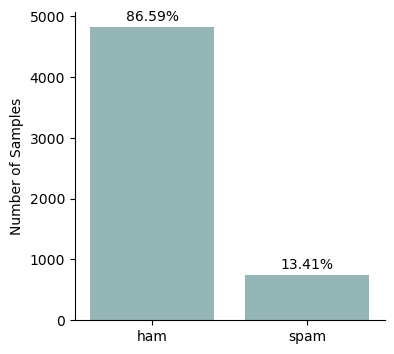

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# label 열의 값 분포 계산
label_counts = df["Label"].value_counts()

# 시각화
plt.figure(figsize=(4, 4))  # figure 크기 설정

# 막대 색상 지정
bar_color = "#8FBCBB"  # 원하는 색상 코드

ax = sns.countplot(x="Label", data=df, color=bar_color)  # countplot 사용

plt.title("")  # 그래프 제목 설정
plt.xlabel("")  # x축 레이블 설정
plt.ylabel("Number of Samples")  # y축 레이블 설정

# 각 레이블의 비율 표시
for i, count in enumerate(label_counts):
    percentage = (count / len(df)) * 100  # 백분율 계산
    plt.text(i, count + 100, f"{percentage:.2f}%", ha="center")  # 텍스트 추가

# 오른쪽 및 위쪽 테두리 제거
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()  # 그래프 출력


## 데이터셋 불균형 해소

머신러닝 모델 훈련 시 가장 흔하게 마주하는 문제 중 하나는 데이터셋의 불균형입니다. 특히 스팸 필터링과 같이 특정 클래스의 데이터가 현저히 적은 경우 모델의 성능 저하를 야기할 수 있습니다.  이를 해결하기 위해 "ham" 메일과 "spam" 메일의 개수를 동일하게 맞춰줍니다.  구체적으로 "ham" 메일 중에서 "spam" 메일의 개수만큼 무작위로 샘플링하여 두 종류의 메일을 합쳐 균형 잡힌 데이터셋을 생성할 것입니다. 이렇게 생성된 `balanced_df`는 "ham"을 0, "spam"을 1로 매핑하여 숫자 레이블로 변환합니다.


In [ ]:
def create_balanced_dataset(df):
    # "spam" 인스턴스 개수 세기
    num_spam = df[df["Label"] == "spam"].shape[0]

    # "spam" 인스턴스 개수와 일치하도록 "ham" 인스턴스 무작위 샘플링
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=42)

    # "ham" 서브셋과 "spam" 데이터 결합
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

print(balanced_df["Label"].value_counts())


Label
0    747
1    747
Name: count, dtype: int64


# 2단계: 사전 훈련된 모델 설정

## 데이터 로더 생성 (Creating data loaders)
앞서 준비한 데이터를 LLM 모델의 학습 데이터로 사용하려면, 메시지 길이가 서로 다르다는 점을 고려해야 합니다. 여러 훈련 예제를 하나의 배치로 묶어 학습하는 과정에서, 메시지 길이가 다르면 문제가 발생할 수 있습니다. 이를 해결하기 위해 다음 두 가지 방법 중 하나를 선택해야 합니다.

1. 데이터셋 또는 배치 내에서 가장 짧은 메시지 길이에 맞춰 모든 메시지를 잘라내는 방법: 이 방법은 간단하지만, 메시지 내용의 일부가 손실될 수 있다는 단점이 있습니다. 특히 중요한 정보가 메시지 앞부분에 위치하는 경우, 정보 손실로 인해 모델 성능이 저하될 수 있습니다.
2. 데이터셋 또는 배치 내에서 가장 긴 메시지 길이에 맞춰 모든 메시지를 패딩하는 방법: 이 방법은 메시지 내용 손실 없이 모든 메시지를 동일한 길이로 맞출 수 있다는 장점이 있습니다. 다만, 패딩된 부분은 모델 학습에 영향을 미치지 않도록 마스크 처리를 해야 합니다.

본 튜토리얼에서는 2번 방법을 선택하여 모든 메시지를 데이터셋에서 가장 긴 메시지 길이에 맞춰 패딩합니다. 패딩된 부분은 모델 학습 시 마스크 처리를 통해 무시하도록 합니다.

## 사전 훈련된 모델 가중치 초기화 (Initializing a model with pretrained weights)

### 모델 선택 (Choosing a model)
본 튜토리얼에서는 `answerdotai/ModernBERT-base` 모델을 사용합니다. 이 모델은 허깅페이스(Hugging Face)의 transformers 라이브러리를 사용하면 간단하게 모델을 불러올 수 있습니다.

### 모델 초기화 (Initializing the model)
`AutoModelForSequenceClassification` 클래스를 사용하여 사전 훈련된 모델을 불러오고, 원하는 task에 맞게 head 부분을 수정합니다. 본 튜토리얼에서는 스팸 메일 분류를 위해 2개의 label (스팸, 햄)을 가진 `classification head`를 사용합니다.


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)

model_id = "answerdotai/ModernBERT-base"

# 토크나이저를 데이터셋 생성 또는 멀티프로세싱 전에 전역적으로 초기화합니다.
tokenizer = AutoTokenizer.from_pretrained(model_id)


# 데이터 로더 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):  # 토크나이저를 인자로 추가
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer  # 전달받은 토크나이저 사용

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }


texts = balanced_df["Text"].to_list()
labels = balanced_df["Label"].to_list()

dataset = CustomDataset(texts, labels, tokenizer)  # 토크나이저 인스턴스 전달
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 모델 로드 및 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
model = model.to(device)

# 모델 학습 설정 및 조정
training_args = TrainingArguments(
    output_dir="../data/output/ModernBERT-spam",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    logging_dir="../data/output/ModernBERT-spam/logs",
    logging_steps=40,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)


Using MPS


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 3단계: 모델 미세 조정

### 모델 가중치 동결 (Freezing pretrained weights)

사전 훈련된 모델의 가중치를 미세 조정(fine-tuning) 과정에서 동결하는 것은 일반적인 방법입니다. 이를 통해 사전 훈련된 모델이 가진 지식을 유지하면서, 특정 task에 맞게 모델을 조정할 수 있습니다. 하지만 여기에서는 모든 가중치를 미세 조정하여 모델 성능을 극대화합니다.

In [ ]:
# 모델 조정 수행
trainer.train()


Step,Training Loss
40,0.251200
80,0.079900
120,0.046400
160,0.027300
200,0.041400
240,0.001200
280,0.000200


TrainOutput(global_step=282, training_loss=0.06348936739650139, metrics={'train_runtime': 250.0251, 'train_samples_per_second': 17.926, 'train_steps_per_second': 1.128, 'total_flos': 381819166460928.0, 'train_loss': 0.06348936739650139, 'epoch': 3.0})

## 모델로 예측하기

앞서 구축하고 미세 조정한 LLM 모델을 이용하여 실제 환경에서 새로운 이메일에 대한 스팸 여부를 예측해보겠습니다. 이 과정은 모델의 실용성을 검증하는 핵심적인 단계입니다.

In [ ]:
# 새로운 데이터에 대한 예측 사용
predict_texts = [
    "CONGRATULATIONS! You've been selected to receive a FREE iPhone 14 Pro Max! Click the link below to claim your prize within the next 30 minutes: bit.ly/free-iphone-claim. Don't miss out on this EXCLUSIVE offer",  # 스팸
    "Hi, how are you? I wanted to catch up and see if you're free for a call sometime this week.",  # 햄
    "Reminder: Don't forget to pick up your dry cleaning today.",  # 햄
]

# 예측 시 *동일한* 토크나이저 인스턴스 사용
predict_encodings = tokenizer(  # 전역적으로 초기화된 토크나이저 사용
    predict_texts, truncation=True, padding=True, return_tensors="pt"
)

# 모델 예측
with torch.no_grad():
    outputs = model(
        input_ids=predict_encodings["input_ids"].to(device),
        attention_mask=predict_encodings["attention_mask"].to(device),
    )

# 예측 결과 추출
predictions = torch.argmax(outputs.logits, dim=-1)

# 예측 결과 해석 및 출력
for text, prediction in zip(predict_texts, predictions):
    if prediction.item() == 1:
        print(f"스팸: {text}")
    else:
        print(f"햄: {text}")


스팸: CONGRATULATIONS! You've been selected to receive a FREE iPhone 14 Pro Max! Click the link below to claim your prize within the next 30 minutes: bit.ly/free-iphone-claim. Don't miss out on this EXCLUSIVE offer
햄: Hi, how are you? I wanted to catch up and see if you're free for a call sometime this week.
햄: Reminder: Don't forget to pick up your dry cleaning today.


위의 출력을 보니 성능이 꽤 괜찮은 것 처럼 보이네요.

## Hugging Face Hub에 모델 저장

이제 미세 조정한 모델을 허깅페이스에 업로드합니다. 이렇게 올려두면 모델을 공유하거나 필요할때 다운로드해서 바로 사용할 수 있습니다.

In [ ]:
# 토크나이저 업로드
tokenizer.push_to_hub("ehottl/ModernBERT-spam")  # 본인 계정 이름과 저장소 이름 작성

# 트레이너를 사용한 모델 업로드
trainer.push_to_hub("ehottl/ModernBERT-spam")  # 본인 계정 이름과 저장소 이름 작성


No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/ehottl/ModernBERT-spam/commit/23f02271322e82762e9c5ca4322dad918205d6bf', commit_message='ehottl/ModernBERT-spam', commit_description='', oid='23f02271322e82762e9c5ca4322dad918205d6bf', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ehottl/ModernBERT-spam', endpoint='https://huggingface.co', repo_type='model', repo_id='ehottl/ModernBERT-spam'), pr_revision=None, pr_num=None)

# 마치며

이번 튜토리얼에서는 사전 훈련된 언어 모델(LLM)을 활용하여 스팸 메일을 분류하는 방법을 단계별로 살펴보았습니다. 데이터셋 준비, 모델 설정, 모델 학습 및 평가를 통해 스팸 메일 분류 모델을 개발하고 배포하는 전체 과정을 경험해 보았습니다. 이 튜토리얼을 통해 독자분들은 LLM 모델을 활용한 텍스트 분류 task에 대한 기본적인 이해를 얻었기를 바랍니다.